In [1]:
!pip install statsmodels==0.14.2
!pip install umap-learn

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv("cars.csv")
df = pd.DataFrame(data).copy()

print(df.head(10))

  manufacturer_name model_name transmission   color  odometer_value  \
0            Subaru    Outback    automatic  silver          190000   
1            Subaru    Outback    automatic    blue          290000   
2            Subaru   Forester    automatic     red          402000   
3            Subaru    Impreza   mechanical    blue           10000   
4            Subaru     Legacy    automatic   black          280000   
5            Subaru    Outback    automatic  silver          132449   
6            Subaru   Forester    automatic   black          318280   
7            Subaru     Legacy    automatic  silver          350000   
8            Subaru    Outback    automatic    grey          179000   
9            Subaru   Forester    automatic  silver          571317   

   year_produced engine_fuel  engine_has_gas engine_type  engine_capacity  \
0           2010    gasoline           False    gasoline              2.5   
1           2002    gasoline           False    gasoline        

In [4]:
print(df.isnull().sum())

manufacturer_name     0
model_name            0
transmission          0
color                 0
odometer_value        0
year_produced         0
engine_fuel           0
engine_has_gas        0
engine_type           0
engine_capacity      10
body_type             0
has_warranty          0
state                 0
drivetrain            0
price_usd             0
is_exchangeable       0
location_region       0
number_of_photos      0
up_counter            0
feature_0             0
feature_1             0
feature_2             0
feature_3             0
feature_4             0
feature_5             0
feature_6             0
feature_7             0
feature_8             0
feature_9             0
duration_listed       0
dtype: int64


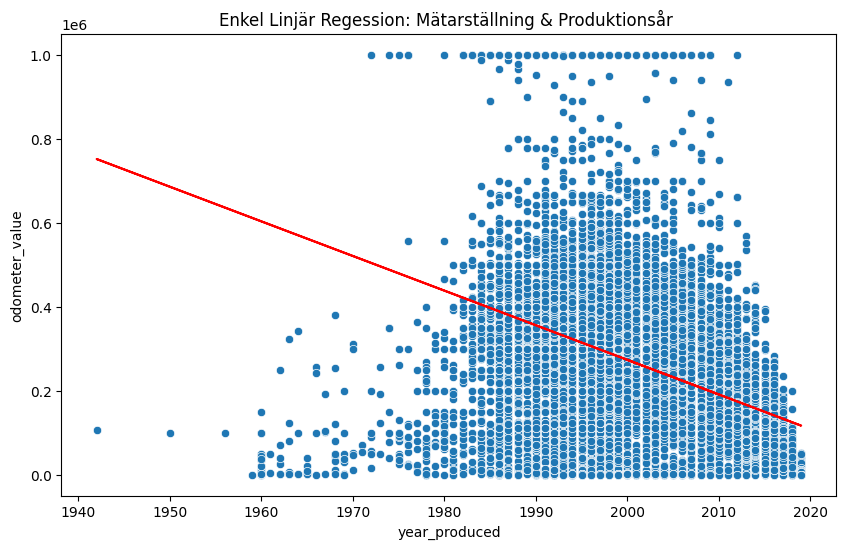

In [5]:
#En enkel linjär regession. För att se om datat är korrekt.
X = df[['year_produced']]  # X-axis
y = df['odometer_value']  # Y-axis

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

plt.figure(figsize=(10,6))
sns.scatterplot(x = 'year_produced', y = 'odometer_value', data = df)
plt.plot(df['year_produced'], model.predict(X), color='red')
plt.title('Enkel Linjär Regession: Mätarställning & Produktionsår ')
plt.ylabel('odometer_value')
plt.xlabel('year_produced')
plt.show()

In [6]:
# Remove rows with null values
df_cleaned = df.dropna()

# Drop the 'location_region' column
df_cleaned = df_cleaned.drop(columns=['location_region'])

# Drop columns 'feature_0' to 'feature_9'
feature_columns = [f'feature_{i}' for i in range(10)]
df_cleaned = df_cleaned.drop(columns=feature_columns)

# Cleaning to get more relevant data
top_15_manufacturers = df_cleaned['manufacturer_name'].value_counts().head(15).index
df_cleaned = df_cleaned[df_cleaned['manufacturer_name'].isin(top_15_manufacturers)]

# One-hot encodting
boolean_columns = df_cleaned.select_dtypes(include=['bool']).columns
df_cleaned = pd.get_dummies(df_cleaned, columns=boolean_columns, drop_first=True)





# Define your target variable
target_variable = 'duration_listed'

# Check if target variable exists in the cleaned DataFrame
if target_variable in df_cleaned.columns:
    # Extract target variable
    y = df_cleaned[target_variable]

    # Z-Score Method
    z_scores = np.abs(stats.zscore(y))
    outliers_z_score = df_cleaned[z_scores > 3]

    # IQR Method
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = df_cleaned[(y < (Q1 - 1.5 * IQR)) | (y > (Q3 + 1.5 * IQR))]

    # Outliers for duration listed is suppose to get removed here but does not work right now (well it sort of works)

In [7]:
#HEJ SKRIV HÄR 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29892.
  res = hypotest_fun_out(*samples, **kwds)


odometer_value:
p värde:(p = 0.000) kolumnen är inte normalfördelad

year_produced:
p värde:(p = 0.000) kolumnen är inte normalfördelad

price_usd:
p värde:(p = 0.000) kolumnen är inte normalfördelad

engine_capacity:
p värde:(p = 0.000) kolumnen är inte normalfördelad

number_of_photos:
p värde:(p = 0.000) kolumnen är inte normalfördelad

up_counter:
p värde:(p = 0.000) kolumnen är inte normalfördelad

duration_listed:
p värde:(p = 0.000) kolumnen är inte normalfördelad



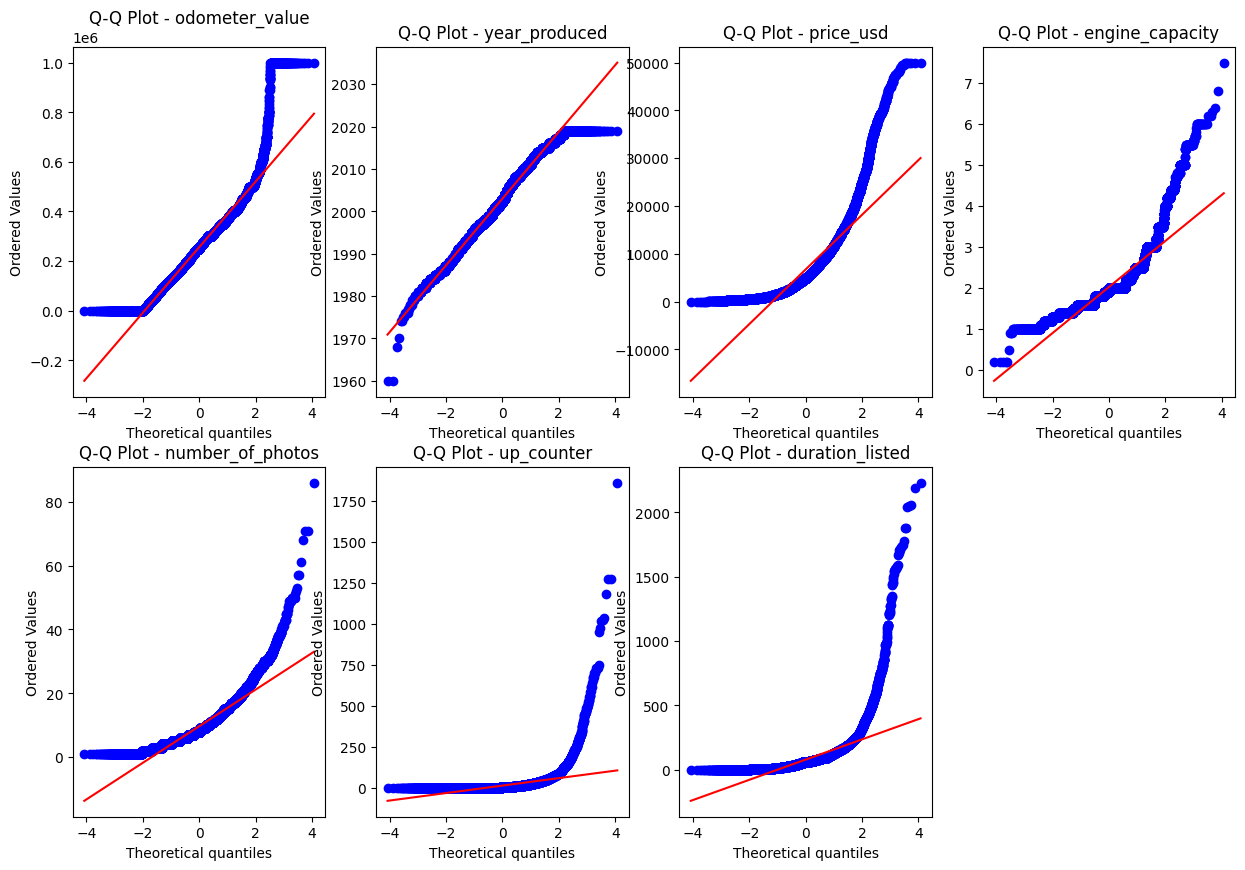

In [8]:
columns_to_impute = df_cleaned[['odometer_value', 'year_produced', 'price_usd', 'engine_capacity',
                                     'number_of_photos', 'up_counter', 'duration_listed']].copy()

plt.figure(figsize=(15, 10))
plotnr = 1

for column in columns_to_impute:
    alpha = 0.05
    stat, p = stats.shapiro(df_cleaned[column])
    if p > alpha:
        print(f"{column}:\np värde:(p = {p:.3f}) kolumnen är normalfördelad\n")
    else:
        print(f"{column}:\np värde:(p = {p:.3f}) kolumnen är inte normalfördelad\n")

    plt.subplot(2, 4, plotnr)
    stats.probplot(df_cleaned[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot - {column}')
    plotnr+=1

In [9]:
manufacturer_counts = df_cleaned['manufacturer_name'].value_counts().reset_index()
manufacturer_counts.columns = ['manufacturer_name', 'count']

fig = px.bar(manufacturer_counts, 
             x='manufacturer_name', 
             y='count', 
             title='Number of Cars by Manufacturer',
             labels={'manufacturer_name': 'Manufacturer', 'count': 'Number of Cars'})

fig.show()

In [10]:
# One-Hot encoding
df_encoded = pd.get_dummies(df_cleaned, columns=['manufacturer_name', 'model_name', 'transmission', 
                                    'color', 'engine_fuel', 'engine_type', 'body_type', 'state', 'drivetrain'])

X = df_encoded.drop(columns=['duration_listed'])
y = df_encoded['duration_listed']

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

pca = PCA(n_components=2)  # Reduce dimensions to 50, for example
X_reduced = pca.fit_transform(X_standardized)

# Apply UMAP
reducer = umap.UMAP(n_neighbors=8, min_dist=0.2, metric='euclidean')
X_embedded = reducer.fit_transform(X_reduced)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5)
df_encoded['cluster'] = kmeans.fit_predict(X_standardized)

# Create a DataFrame for Plotly Express
df_umap = pd.DataFrame(X_embedded, columns=['UMAP Component 1', 'UMAP Component 2'])
df_umap['cluster'] = df_encoded['cluster']

# Plot with Plotly Express
fig = px.scatter(df_umap, x='UMAP Component 1', y='UMAP Component 2', color='cluster',
                 color_continuous_scale='viridis', title='UMAP Projection with Clustering')

fig.update_layout(coloraxis_colorbar_title='Cluster')
fig.show()

In [11]:
# One-Hot encoding
df_encoded = pd.get_dummies(df_cleaned, columns=['manufacturer_name', 'model_name', 'transmission', 
                                    'color', 'engine_fuel', 'engine_type', 'body_type', 'state', 'drivetrain'])

X = df_encoded.drop(columns=['price_usd'])
y = df_encoded['price_usd']

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

pca = PCA(n_components=10)  # Reduce dimensions to 50, for example
X_reduced = pca.fit_transform(X_standardized)

# Apply UMAP
reducer = umap.UMAP(n_neighbors=500, min_dist=0.3, metric='euclidean')
X_embedded = reducer.fit_transform(X_reduced)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5)
df_encoded['cluster'] = kmeans.fit_predict(X_standardized)

# Create a DataFrame for Plotly Express
df_umap = pd.DataFrame(X_embedded, columns=['UMAP Component 1', 'UMAP Component 2'])
df_umap['cluster'] = df_encoded['cluster']

# Plot with Plotly Express
fig = px.scatter(df_umap, x='UMAP Component 1', y='UMAP Component 2', color='cluster',
                 color_continuous_scale='viridis', title='UMAP Projection with Clustering')

fig.update_layout(coloraxis_colorbar_title='Cluster')
fig.show()

In [12]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3)
df_encoded['cluster'] = kmeans.fit_predict(X_standardized)

# Create a DataFrame for Plotly Express
df_pca = pd.DataFrame(X_pca, columns=['PCA Component 1', 'PCA Component 2'])
df_pca['cluster'] = df_encoded['cluster']

# Plot with Plotly Express
fig = px.scatter(df_pca, x='PCA Component 1', y='PCA Component 2', color='cluster',
                 color_continuous_scale='viridis', title='PCA Projection with Clustering')

fig.update_layout(coloraxis_colorbar_title='Cluster')
fig.show()

           count        mean         std  min   25%   50%     75%     max
cluster                                                                  
0           26.0  131.115385  229.239495  3.0  46.0  69.5  113.75  1210.0
1        18547.0   77.664312  104.320290  0.0  23.0  59.0   90.00  2232.0
2        11319.0   79.504903  111.944525  0.0  22.0  59.0   91.00  2056.0


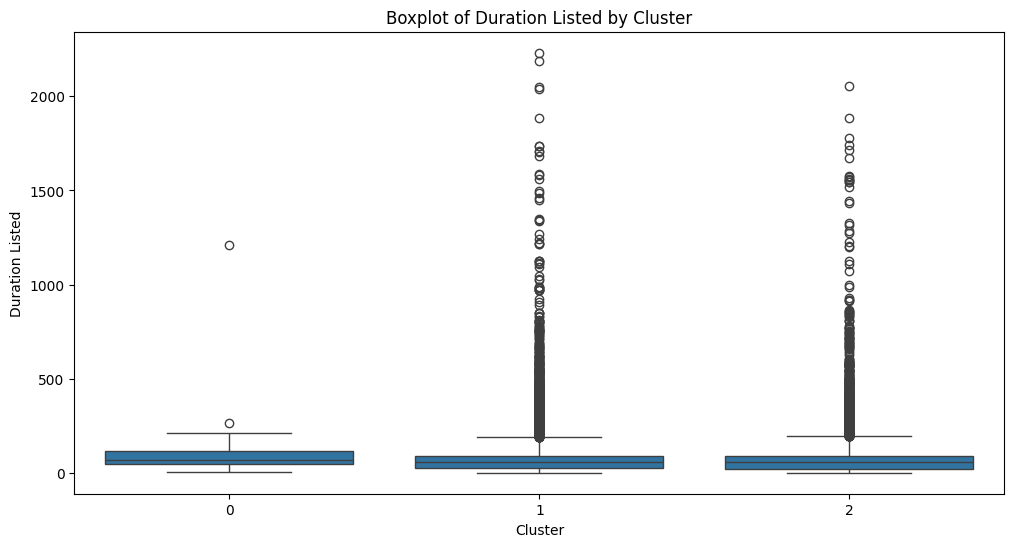

cluster
0    131.115385
1     77.664312
2     79.504903
Name: duration_listed, dtype: float64


In [13]:
# Apply KMeans clustering
clusters = kmeans.fit_predict(X_standardized)

# Add cluster labels to DataFrame
df_encoded['cluster'] = clusters
df_pca = pd.DataFrame(X_pca, columns=['PCA Component 1', 'PCA Component 2'])
df_pca['cluster'] = clusters
df_pca['duration_listed'] = y

# Examine cluster characteristics with respect to duration_listed
cluster_summary = df_encoded.groupby('cluster')['duration_listed'].describe()
print(cluster_summary)

# Visualize cluster distribution of duration_listed
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='duration_listed', data=df_encoded)
plt.title('Boxplot of Duration Listed by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Duration Listed')
plt.show()

# Visualize using Plotly Express
fig = px.box(df_encoded, x='cluster', y='duration_listed', title='Boxplot of Duration Listed by Cluster')
fig.show()

# Compare average duration_listed across clusters
avg_duration_by_cluster = df_encoded.groupby('cluster')['duration_listed'].mean()
print(avg_duration_by_cluster)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f5200bc7-c442-4bd2-9d51-fead2e329527' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>